# Tensil TCU Demo - YoloV4-tiny

In [3]:
model_hw = 416

### Import the TCU driver

In [4]:
import sys
sys.path.append('/home/xilinx/')

import time
import math
import numpy as np
import tflite_runtime.interpreter as tflite
import cv2
import matplotlib.pyplot as plt
import pynq

from pynq import Overlay
from pynq.lib.video import *

from tcu_pynq.driver import Driver
from tcu_pynq.util import div_ceil
from tcu_pynq.architecture import zcu104

### Configure the fabric and driver

In [6]:
overlay = Overlay('/home/xilinx/tensil_zcu104.bit')
tcu = Driver(zcu104, overlay.axi_dma_0)

## Demo: YoloV4-tiny inference

In this demo, we show how to run the bulk of the model (>97% of computation) on the TCU while handling the last few operations on the CPU using tflite. This configuration allows you to run more specialized operations that are not supported by the TCU.

### Load the model

In [7]:
tcu.load_model('/home/xilinx/yolov4_tiny_{0}_onnx_zcu104.tmodel'.format(model_hw))

### Instantiate tflite interpreter

In [8]:
interpreter = tflite.Interpreter(model_path='/home/xilinx/yolov4_tiny_{0}_post.tflite'.format(model_hw))
interpreter.allocate_tensors()

### Get input data

In [9]:
original_image = cv2.imread("/home/xilinx/yolo_img/dog.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image = cv2.resize(original_image, (model_hw, model_hw))

image_data = original_image / 255.
image_data = np.pad(image_data, [(0, 0), (0, 0), (0, tcu.arch.array_size - 3)], 'constant', constant_values=0)

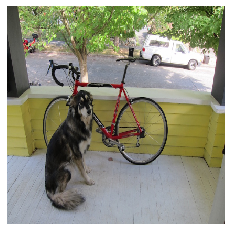

In [10]:
fig, axes1 = plt.subplots()
axes1.set_axis_off()
axes1.imshow(original_image)

### Run inference on TCU

In [12]:
inputs = {'x:0': image_data}

start = time.time()

outputs = tcu.run(inputs)

end = time.time()
print("Ran backbone inference in {:.4}s".format(end - start))
print()

print(outputs['model/conv2d_17/BiasAdd:0'])
print(outputs['model/conv2d_20/BiasAdd:0'])

Ran backbone inference in 0.4645s

[ 0.95703125  0.53515625 -0.12109375 ... -5.5703125  -4.8046875
  0.        ]
[ 0.35546875  0.3203125   0.2109375  ... -6.8828125  -6.22265625
  0.        ]


### Run inference in tflite

In [13]:
def set_tensor(driver, interpreter, hw_size, data):
    input_details = interpreter.get_input_details()
    input_idxs = [i for i in range(len(input_details))
                  if input_details[i]['shape'][1] == hw_size and input_details[i]['shape'][2] == hw_size]
    inp = input_details[input_idxs[0]]
    data = data.astype(inp['dtype'])
    inner_dim = inp['shape'][-1]
    inner_size = div_ceil(inner_dim, driver.arch.array_size) * driver.arch.array_size
    if inner_size != inner_dim:
        data = data.reshape((-1, inner_size))[:, :inner_dim]
    data = data.reshape(inp['shape'])
    interpreter.set_tensor(inp['index'], data)

In [14]:
set_tensor(tcu, interpreter, model_hw / 32, np.array(outputs['model/conv2d_17/BiasAdd:0']))
set_tensor(tcu, interpreter, model_hw / 16, np.array(outputs['model/conv2d_20/BiasAdd:0']))

In [15]:
start = time.time()
interpreter.invoke()
end = time.time()
print("Ran head inference in {:.4}s".format(end - start))
print()

Ran head inference in 0.007509s



In [16]:
output_details = interpreter.get_output_details()
scores, boxes_xywh = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]

### Display results

In [17]:
def filter_and_reshape(boxes, scores, score_threshold=0.4):
    scores_max = np.max(scores, axis=-1)
    mask = scores_max > score_threshold
    
    filtered_boxes = boxes[mask]
    filtered_scores = scores[mask]
    
    filtered_boxes = np.reshape(filtered_boxes, [scores.shape[0], -1, filtered_boxes.shape[-1]])    
    filtered_scores = np.reshape(filtered_scores, [scores.shape[0], -1, filtered_scores.shape[-1]])

    return filtered_boxes, filtered_scores

In [18]:
boxes_xywh, scores = filter_and_reshape(boxes_xywh, scores)

In [19]:
boxes_xy, boxes_wh = np.split(boxes_xywh, (2,), axis=-1)
boxes_x0y0x1y1 = np.concatenate([boxes_xy - boxes_wh/2, boxes_xy + boxes_wh/2], axis=-1)

In [20]:
def non_maximum_suppression(boxes, iou_threshold=0.4):
    if len(boxes) == 0:
        return boxes
    
    area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    ll_x = np.maximum.outer(boxes[:, 0], boxes[:, 0])
    ll_y = np.maximum.outer(boxes[:, 1], boxes[:, 1])
    ur_x = np.minimum.outer(boxes[:, 2], boxes[:, 2])
    ur_y = np.minimum.outer(boxes[:, 3], boxes[:, 3])
    intersection_x = np.maximum(0, ur_x - ll_x)
    intersection_y = np.maximum(0, ur_y - ll_y)
    intersection = intersection_x * intersection_y
    
    iou = intersection / area - np.identity(area.shape[-1])
    p = iou >= iou_threshold
    p = p & p.T
    n =  p.shape[-1]
    
    no_needs_merge = set()
    for i in range(n):
        if not p[i].any():
            no_needs_merge.add(i)
    
    needs_merge = set()
    for i in range(n):
        for j in range(n):
            if p[i, j]:
                needs_merge.add(tuple(sorted((i, j))))

    def merge(needs_merge):
        result = set()
        discarded = set()
        for indices in needs_merge:
            idx = indices[0]
            if idx not in discarded:
                result.add(indices[0])
            discarded.add(indices[1])
            if indices[1] in result:
                result.remove(indices[1])
        return result

    return sorted(list(no_needs_merge) + list(merge(needs_merge)))

In [21]:
box_indices = non_maximum_suppression(boxes_x0y0x1y1[0])

In [22]:
with open('/home/xilinx/coco-labels-2014_2017.txt') as f:
    labels_coco = f.read().split('\n')

truck = 0.63
dog = 0.78
bicycle = 0.55


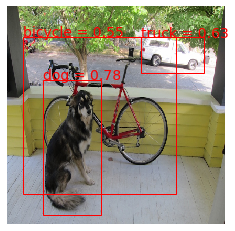

In [23]:
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(original_image)

for i in box_indices:
    category_idx = np.argmax(scores, axis=-1)[0, i]
    category_conf = np.max(scores, axis=-1)[0, i]
    
    text = f'{labels_coco[category_idx]} = {category_conf:.2}'
    print(text)
    
    box_x0y0x1y1 = boxes_x0y0x1y1[0, i]    
    x = box_x0y0x1y1[0]
    y = box_x0y0x1y1[1]
    dx = (box_x0y0x1y1[2] - box_x0y0x1y1[0])
    dy = (box_x0y0x1y1[3] - box_x0y0x1y1[1])
    
    ax.text(x, y-1, text, fontsize=14, color='red')
    ax.add_patch(plt.Rectangle((x, y), dx, dy,
             edgecolor = 'red',
             fill=False,
             lw=1))